# Alrawiyah الرّاوية 
Arabic Poetry Recommender (The Training Code)

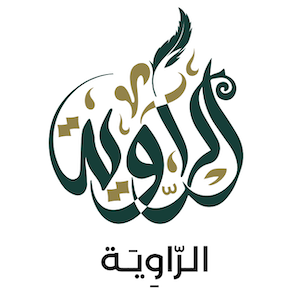

In [10]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import requests 

from tqdm import tqdm
tqdm.pandas()

from PIL import Image

import cv2

from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

import torch.nn as nn
import numpy as np


import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


#### 1. Prepare dataset

In [76]:
df_data = pd.read_csv('/content/drive/MyDrive/alrawiyah/data/twitter_unsplash/tweets_train_v2_fullsearch_cleaned_filtered1024.csv');

In [77]:
df_data.head()

,Unnamed: 0,id,tweet,thumb,image_file,tweet_cleaned
0,0,Ct1Mx5OTn9A,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1487139975590-b4f1dce9b035.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
1,1,6T7kfc3VitU,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,https://s3.us-west-2.amazonaws.com/images.unsp...,RgJQ82pETlKd0B7QzcJO_5912578701_92397ba76c_b.j...,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
2,2,vs6a4EHj_Ro,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1447875569765-2b3db822bec9.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
3,3,7NBO76G5JsE,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1516205651411-aef33a44f7c2.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
4,4,yanhwFwyoaU,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1538998073820-4dfa76300194.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...


In [78]:
# get image names 

df_data['image_file'] = df_data['thumb'].str.split('/').str[-1]
df_data['image_file'].loc[df_data['image_file'].str.endswith('.jpg')].apply(lambda x: x.split('.')[0])
df_data['image_file'] = df_data['image_file'] + '.jpg'

In [79]:
df_data.drop(['Unnamed: 0'], axis = 1, inplace= True)

In [80]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1023 non-null   object
 1   tweet          1023 non-null   object
 2   thumb          1023 non-null   object
 3   image_file     1023 non-null   object
 4   tweet_cleaned  1023 non-null   object
dtypes: object(5)
memory usage: 40.1+ KB


In [81]:
# download all images to google drive

for row in tqdm(df_data.iterrows()): 
    url = row[1]['thumb']
    result = requests.get(url, stream=True) 
    image = result.raw.read() 
    open('/content/drive/MyDrive/alrawiyah/data/twitter_unsplash/images/'+ row[1]['image_file'] ,"wb").write(image) 

0it [00:00, ?it/s]

In [82]:
# preprocess original tweets

def remove_digits(text):
  return re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  
def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
   
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))

    return text.translate(translator)

def normalize_arabic(text):
    #text = re.sub("[إأآا]", "ا", text)
    #text = re.sub("ئ", "ي", text)
    #text = re.sub("ى", "ي", text)
    #text = re.sub("ؤ", "ء", text)
    #text = re.sub("ئ", "ء", text)
    #text = re.sub("ة", "ه", text)
    #text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
  arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
  text = re.sub(arabic_diacritics, '', text)
  return text  

In [ ]:
df_data['tweet'] = df_data['tweet'].apply(lambda x: remove_digits(x))
df_data['tweet'] = df_data['tweet'].apply(lambda x: remove_punctuations(x))
df_data['tweet'] = df_data['tweet'].apply(lambda x: remove_diacritics(x))

In [ ]:
df_data['tweet'].head()

####2. Tokenization , Stemming and Lemmatization

In [ ]:
df_data['tweet_cleaned'] = df_data['tweet']

In [ ]:
df_data.head()

,id,tweet,tweet_en,thumb,image_file,tweet_cleaned
0,Ct1Mx5OTn9A,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,"For all those who have lost you, his heart, no...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1487139975590-b4f1dce9b035.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
1,6T7kfc3VitU,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,"For all those who have lost you, his heart, no...",https://s3.us-west-2.amazonaws.com/images.unsp...,RgJQ82pETlKd0B7QzcJO_5912578701_92397ba76c_b.j...,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
2,vs6a4EHj_Ro,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,"For all those who have lost you, his heart, no...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1447875569765-2b3db822bec9.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
3,7NBO76G5JsE,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,"For all those who have lost you, his heart, no...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1516205651411-aef33a44f7c2.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
4,yanhwFwyoaU,فما كل من تهواه يهواك قلبه ولا كل من صافيته لك...,"For all those who have lost you, his heart, no...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1538998073820-4dfa76300194.jpg,فما تها يها قلب صفي صفا اذا يكن صفو ودد طبع خي...
5,VuBzplNNi0k,فيا فالق الإصباح والحب والنوى ويا قاسم الأرزاق...,"So, the sake of morning, love, and nuclei, and...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1435820394963-a15297f976fd.jpg,فيا فلق صبح لحب نوى ويا قسم كفل حيت لج بحر ويا...
6,okVXy9tG3KY,فيا فالق الإصباح والحب والنوى ويا قاسم الأرزاق...,"So, the sake of morning, love, and nuclei, and...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1505118380757-91f5f5632de0.jpg,فيا فلق صبح لحب نوى ويا قسم كفل حيت لج بحر ويا...
7,twoEJNpgdbI,فيا فالق الإصباح والحب والنوى ويا قاسم الأرزاق...,"So, the sake of morning, love, and nuclei, and...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1516980907201-943c13a8d03c.jpg,فيا فلق صبح لحب نوى ويا قسم كفل حيت لج بحر ويا...
8,xe-ss5Tg2mo,فيا فالق الإصباح والحب والنوى ويا قاسم الأرزاق...,"So, the sake of morning, love, and nuclei, and...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1497290756760-23ac55edf36f.jpg,فيا فلق صبح لحب نوى ويا قسم كفل حيت لج بحر ويا...
9,ka7REB1AJl4,فيا فالق الإصباح والحب والنوى ويا قاسم الأرزاق...,"So, the sake of morning, love, and nuclei, and...",https://s3.us-west-2.amazonaws.com/images.unsp...,photo-1516967124798-10656f7dca28.jpg,فيا فلق صبح لحب نوى ويا قسم كفل حيت لج بحر ويا...


In [ ]:
import nltk
from nltk.stem.isri import ISRIStemmer
ISRIS_st = ISRIStemmer()

# Tokenization
df_data['tweet_cleaned'] = df_data['tweet_cleaned'].progress_apply(lambda x: x.split())

100%|██████████| 19538/19538 [00:00<00:00, 58359.01it/s]


In [ ]:
# Stemming
df_data['tweet_cleaned'] = df_data['tweet_cleaned'].progress_apply(lambda x: [ISRIS_st.stem(item) for item in x])

100%|██████████| 19538/19538 [00:04<00:00, 4667.11it/s]


In [ ]:
#Remove stop-words

nltk.download('stopwords')
stop = stopwords.words('arabic')
set(stopwords.words('arabic'))
df_data['tweet_cleaned'] = df_data['tweet_cleaned'].progress_apply(lambda x: [item for item in x if item not in stop])

100%|██████████| 19538/19538 [00:08<00:00, 2296.90it/s]


In [ ]:
df_data['tweet_cleaned'] = df_data['tweet_cleaned'].str.join(' ')

In [ ]:
# Save the processed poems into file
df_data.to_csv('tweets_train_v2_fullsearch_cleaned.csv', encoding='utf-8')

#### 3. Build the model

In [2]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 


In [3]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [75]:
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

import torch.nn as nn
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


from CLIP import clip

In [76]:
class CLIP_Net(nn.Module):
    def __init__(self, features_image=1280,features_text=768,projection_dim=256,normalize=1):
        super(CLIP_Net, self).__init__()

        self.backbone,  self.preprocessor = clip.load('ViT-B/32', device,jit=False)
        self.Dense=nn.Linear(768,512).to(device)

        self.logit_scale = nn.Parameter(torch.ones([]))

    def forward(self,x_im,x_tx):
    
        image_features, text_features = self.backbone(x_im, x_tx)
        

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.logit_scale.exp()
        logits_per_iamge = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_iamge, logits_per_text

In [77]:
class Arabic_image_poetry_DataSet(Dataset):
    def __init__(self, img_dir, text_dir, tfms, tockenizer):
        self.img_dir = img_dir
        self.pd_text =  pd.read_csv(text_dir)
        self.tfms = tfms
        self.tockenizer = tockenizer
        self.all_imgs = os.listdir(img_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):


        res = dict()
        text_sentence = list()
        text_sentence.append(self.pd_text['tweet_cleaned'].str.slice(0,76)[idx])
        res['text'] = self.tockenizer.tokenize(text_sentence).squeeze(0).to('cuda')

        image = cv2.imread(self.img_dir + self.pd_text['image_file'][idx])
        image=Image.fromarray(np.uint8(image)).convert('RGB')


        res['image'] = self.tfms(image)
 
        return res

#### 4. Evaluation functions

In [7]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def recall_at_k(rank, plabels=None, glabels=None, k=1):
    """Compute R@K: Recall@K (K=1, 5, 10) represents the percentage of the queries
    where at least one ground-truth is retrieved among the top-K results.
    ---------------------------------------------------
    Inputs:
    distmat : numpy.ndarray
        The distance matrix. ``distmat[i, j]`` is the distance between i-th
        probe sample and j-th gallery sample.
    glabels : numpy.ndarray or None, optional
    plabels : numpy.ndarray or None, optional
    ---------------------------------------------------
    Outputs:
    out : numpy.ndarray, The recall@k accuracy
    ---------------------------------------------------
    """
    n_probe, n_gallery = rank.shape
    match = 0
    for i in range(n_probe):
        match += int(sum(glabels[rank[i, :k]] == plabels[i]) > 0)

    score = match * 1.0 / n_probe

    return score


def mean_average_precision(rank, plabels=None, glabels=None):
    """Compute the Mean Average Precision.
    ---------------------------------------------------
    Inputs:
    distmat : numpy.ndarray
        The distance matrix. ``distmat[i, j]`` is the distance between i-th
        probe sample and j-th gallery sample.
    glabels : numpy.ndarray or None, optional
    plabels : numpy.ndarray or None, optional
    ---------------------------------------------------
    Outputs:
    out : numpy.ndarray, The MAP result
    ---------------------------------------------------
    """
    n_probe, n_gallery = rank.shape
    average_precision = 1.0 * np.zeros_like(plabels)

    for i in range(n_probe):
        relevant_size = sum(glabels == plabels[i])
        hit_index = np.where(glabels[rank[i, :]] == plabels[i])
        precision = 1.0 * np.zeros_like(hit_index[0])
        assert relevant_size == hit_index[0].shape[0]
        for j in range(relevant_size):
            hitid = max(1, hit_index[0][j])
            precision[j] = sum(glabels[rank[i, :hitid]] == plabels[i]) * 1.0 / (hit_index[0][j] + 1)
        average_precision[i] = np.sum(precision) * 1.0 / relevant_size

    score = np.mean(average_precision)

    return score


def _eval_retrieval(PX, PY, GX, GY):
    #Text_X, Text_Y, Image_X, Image_Y
    # D_{i, j} is the distance between the ith array from PX and the jth array from GX.
    D = pairwise_distances(PX.cpu(), GX.cpu(), metric='cosine')

    Rank = np.argsort(D, axis=1)

    # Evaluation
    recall_1 = 100*recall_at_k(Rank, PY, GY, k=1)  # Recall @ K
    print ('Recall@1=', recall_1)

    recall_5 = 100*recall_at_k(Rank, PY, GY, k=5)  # Recall @ K
    print ('Recall@5=', recall_5)

    recall_10 = 100*recall_at_k(Rank, PY, GY, k=10)  # Recall @ K
    print ('Recall@10=', recall_10)

    recall_20 = 100 * recall_at_k(Rank, PY, GY, k=20)  # Recall @ K
    print('Recall@20=', recall_20)


    return recall_1, recall_5, recall_10, recall_20


def average_precision_at_k(rank, plabels=None, glabels=None, k=50):
    """Compute AP@K: We report the AP@K, the percent of top-K scoring images whose
    class matches that of the text query, averaged over all the test classes.
    ---------------------------------------------------
    Inputs:
    distmat : numpy.ndarray
        The distance matrix. ``distmat[i, j]`` is the distance between i-th
        probe sample and j-th gallery sample.
    glabels : numpy.ndarray or None, optional
    plabels : numpy.ndarray or None, optional
    ---------------------------------------------------
    Outputs:
    out : numpy.ndarray, The AP@K accuracy
    ---------------------------------------------------
    """
    n_probe, n_gallery = rank.shape
    match = 0
    average_precision = 1.0 * np.zeros_like(plabels)

    for i in range(n_probe):
        relevant_size = sum(glabels == plabels[i])
        hit_index = np.where(glabels[rank[i, :k]] == plabels[i])
        precision = 1.0 * np.zeros_like(hit_index[0])
        for j in range(hit_index[0].shape[0]):
            hitid = max(1, hit_index[0][j])
            precision[j] = sum(glabels[rank[i, :hitid]] == plabels[i]) * 1.0 / (hit_index[0][j] + 1)
        average_precision[i] = np.sum(precision) * 1.0 / relevant_size

    score = np.mean(average_precision)

    return score

In [18]:
# evaluate model
def Eval_model(loader, model):
        test_image_features = []
        test_text_features = []
        # test_dataset=train_dataset
        Truth_text=[]
        Truth_image=[]
        for i,batch_test in enumerate(loader):

            with torch.no_grad():

                img_features =model.backbone.encode_image(batch_test['image'].to(device))
                txt_features = model.backbone.encode_text(batch_test['text'].to(device)) 
                test_image_features.append(img_features.squeeze(0))
                test_text_features.append(txt_features.squeeze(0))
                Truth_text.append(i+1)
                Truth_image.append(i+1)


        Test_Image_Feat = (torch.stack(test_image_features, dim=0))
        Test_Text_Feat = (torch.stack(test_text_features, dim=0))

        Truth_text = np.array(Truth_text)
        Truth_image = np.array(Truth_image)

        #print("Text-to-Image Evaluation...")
        #_eval_retrieval(Test_Text_Feat, Truth_text, Test_Image_Feat, Truth_image)
        print("Image-to-Text Evaluation...")
        _eval_retrieval(Test_Image_Feat, Truth_image, Test_Text_Feat, Truth_text)

#### 5. Create the dataset loader

In [78]:
tfms = transforms.Compose([
    # get a set of data augmentation transformations as described in the SimCLR paper.
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])


img_dir = '/content/drive/MyDrive/alrawiyah/data/twitter_unsplash/images/'
txt_dir = '/content/drive/MyDrive/alrawiyah/data/twitter_unsplash/tweets_train_v2_fullsearch_cleaned_filtered1024.csv'
dataset = Arabic_image_poetry_DataSet(img_dir, txt_dir, tfms=tfms, tockenizer=clip)

In [79]:
torch.manual_seed(0)
train_size = 350  # 80%
test_size = 88  # 20%
batch_size = 8


dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [80]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


#### 6. Load and train the model

In [82]:
# load model

device = "cuda" if torch.cuda.is_available() else "cpu"
Poems_model = CLIP_Net().to(device)

epochs = 30

In [83]:
# train model on twitter splash dataset

Criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(Poems_model.parameters(), lr=0.01,nesterov=True,momentum=0.9)

## train on one text
training_loss = []
for epoch in tqdm(range(0, epochs)):
    if epoch == 40:
        optimizer = torch.optim.SGD(Poems_model.parameters(), lr=0.001, nesterov=True, momentum=0.9)
    if epoch == 80:
        optimizer = torch.optim.SGD(Poems_model.parameters(), lr=0.0001, nesterov=True, momentum=0.9)

    losses = []
    optimizer.zero_grad()

    # Train:
    for batch_idx, batch_data in enumerate(trainloader):

        logits_image, logits_text = Poems_model(batch_data['image'].to(device=device), batch_data['text'].to(device=device))
        labels = torch.Tensor(np.arange(len(batch_data['image']))).to(device).long()
        loss = 0.5 * Criterion(logits_image, labels) + 0.5 * Criterion(logits_text, labels)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(Poems_model.parameters(), 0.1)
        optimizer.step()
        optimizer.zero_grad()


    training_loss.append(np.average(losses))
    print('epoch: \t', epoch, '\t [Loss   : {:.3f}]'.format(training_loss[epoch]))
    if epoch % 10 == 0:
        print('Results on Test.........................................')
        Eval_model(loader=testloader, model=Poems_model)

########
print("**************************************************************************************")
print("Final Evaluation........")
print("**************************************************************************************")
Eval_model(loader=testloader, model=Poems_model)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 	 0 	 [Loss   : 2.071]
Results on Test.........................................
Image-to-Text Evaluation...
Recall@1= 0.0
Recall@5= 6.8181818181818175
Recall@10= 12.5
Recall@20= 28.40909090909091
epoch: 	 1 	 [Loss   : 2.060]
epoch: 	 2 	 [Loss   : 2.026]
epoch: 	 3 	 [Loss   : 2.009]
epoch: 	 4 	 [Loss   : 1.889]
epoch: 	 5 	 [Loss   : 1.745]
epoch: 	 6 	 [Loss   : 1.717]
epoch: 	 7 	 [Loss   : 1.663]
epoch: 	 8 	 [Loss   : 1.524]
epoch: 	 9 	 [Loss   : 1.516]
epoch: 	 10 	 [Loss   : 1.427]
Results on Test.........................................
Image-to-Text Evaluation...
Recall@1= 3.4090909090909087
Recall@5= 15.909090909090908
Recall@10= 20.454545454545457
Recall@20= 45.45454545454545
epoch: 	 11 	 [Loss   : 1.414]
epoch: 	 12 	 [Loss   : 1.392]
epoch: 	 13 	 [Loss   : 1.335]
epoch: 	 14 	 [Loss   : 1.315]
epoch: 	 15 	 [Loss   : 1.317]
epoch: 	 16 	 [Loss   : 1.217]
epoch: 	 17 	 [Loss   : 1.194]
epoch: 	 18 	 [Loss   : 1.193]
epoch: 	 19 	 [Loss   : 1.232]
epoch: 	 20 	 [

#### 7. Save the model


In [84]:
torch.save({
        'model_state_dict': Poems_model.state_dict(),
        }, f"/content/drive/MyDrive/alrawiyah/model_checkpoint/Poems_model_50_epochs.pt") 

#### 8. Save the poems embeddings


In [ ]:
df_metrec = pd.read_csv('/content/drive/MyDrive/alrawiyah/data/metrec/metrec_dataset_clean.csv');

In [63]:
df_metrec.head()

,Unnamed: 0,text,text_clean
0,0,يا ضيف طيف ما هداه لمضجعي إلا لهيب في الحشى ...,ضيف طيف هده ضجع الا لهب حشى وقد
1,1,إمامك الصبح كم يشكو دجى ووجى فظاظة الشوك قد ...,ممك صبح شكو دجى وجى فظظ شوك تفض الى رطب
2,2,وعيون نرجه لنحوك قد رنت وغدت تشير اليك بالايماء,وعي نرج رنت وغد تشر الك يمء
3,3,قطعت مكاتبتي عنكم لأجل حديث إليكم يساق,قطع كتب عنكم حدث الي يسق
4,4,ليخف صاحب الديانة والصون مقالا من جاهل يتحظى,يخف صحب دين لصو قلا جهل حظى


In [86]:
metrec_text = clip.tokenize(df_metrec['text_clean'].iloc[0:10000].to_list()).to(device)

with torch.no_grad():
    text_features = Poems_model.backbone.encode_text(metrec_text)

In [ ]:
torch.save(text_features, 'poems_emb_metrec_10000.pt')

#### 9. Load the model

In [1]:
Poems_model = CLIP_Net().to(device)

NameError: ignored

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/alrawiyah/model_checkpoint/Poems_model_10_epochs.pt")

In [ ]:
# Use these 3 lines if you use default model setting(not training setting) of the clip. For example, if you set context_length to 100 since your string is very long during training, then assign 100 to checkpoint['model_state_dict']["context_length"] 
checkpoint['model_state_dict']["input_resolution"] = Poems_model.backbone.input_resolution #default is 224
checkpoint['model_state_dict']["context_length"] = Poems_model.backbone..context_length # default is 77
checkpoint['model_state_dict']["vocab_size"] = Poems_model.backbone..vocab_size 

In [ ]:
Poems_model.backbone.load_state_dict(checkpoint['model_state_dict'])

#### 8. Test the model

In [ ]:
#@title اختبر النموذج{ display-mode: "form" }


Select = "flower"  #@param ['birds', 'door', 'flower', 'makkah', 'sea_sky', 'sunset']

Poems_Number = 1 #@param {type:"slider", min:1, max:10, step:1}


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [58]:
%%capture
!pip install sentence-transformers

In [ ]:
from sentence_transformers import util

In [68]:
poems_emb_metrec = torch.load('poems_emb_metrec_1000.pt')

In [ ]:
image = preprocess(Image.open("/content/drive/MyDrive/alrawiyah/test_images/test2.jpg")).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)

hits = util.semantic_search(image_features, text_features, top_k=5)[0]


In [95]:
 for hit in hits:
        print(df_metrec['text'].iloc[hit['corpus_id']], hit['score'])

فلست بالصب ولا الواجد إن   لم أفن في وجدي بكم وجودي 0.1505126953125
ي ق  ت  ص وق د ح ص  دوه له   م ن ه ام ع داه في ح ص ده 0.1407470703125
لا غير الله ما بالقوم من نعم   ما غيروا ما بنا منهم من النعم 0.1341552734375
ومن هو حاسد النعما   ومن في الفضل محسود 0.128173828125
من مجيري من لواحظه   إنني منها على وجل 0.12744140625


#### 9. Sample Results

Query:


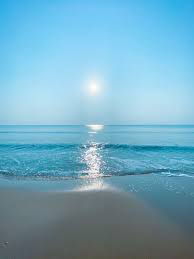

رمى البحر نحوك أمواجه   فعاندت تياره الأزرقا 0.29032623767852783
والبدر لمحة نور منك نبصرها   والبحر قطرة ماء من غواديكا 0.29001712799072266
الله أنشأه من نوره بشرا   وأنشأ الخلق من ماء ومن طين 0.28542524576187134
الله أنشأه من نوره بشرا   وأنشأ الخلق من ماء ومن طين 0.28542524576187134
نسب أبهر من شمس الضحى   ليس ماء المزن منه أطهرا 0.28291055560112


In [ ]:
filepath = '/content/test2.jpg'
display(query_img)
search(Image.open(filepath))

Query:


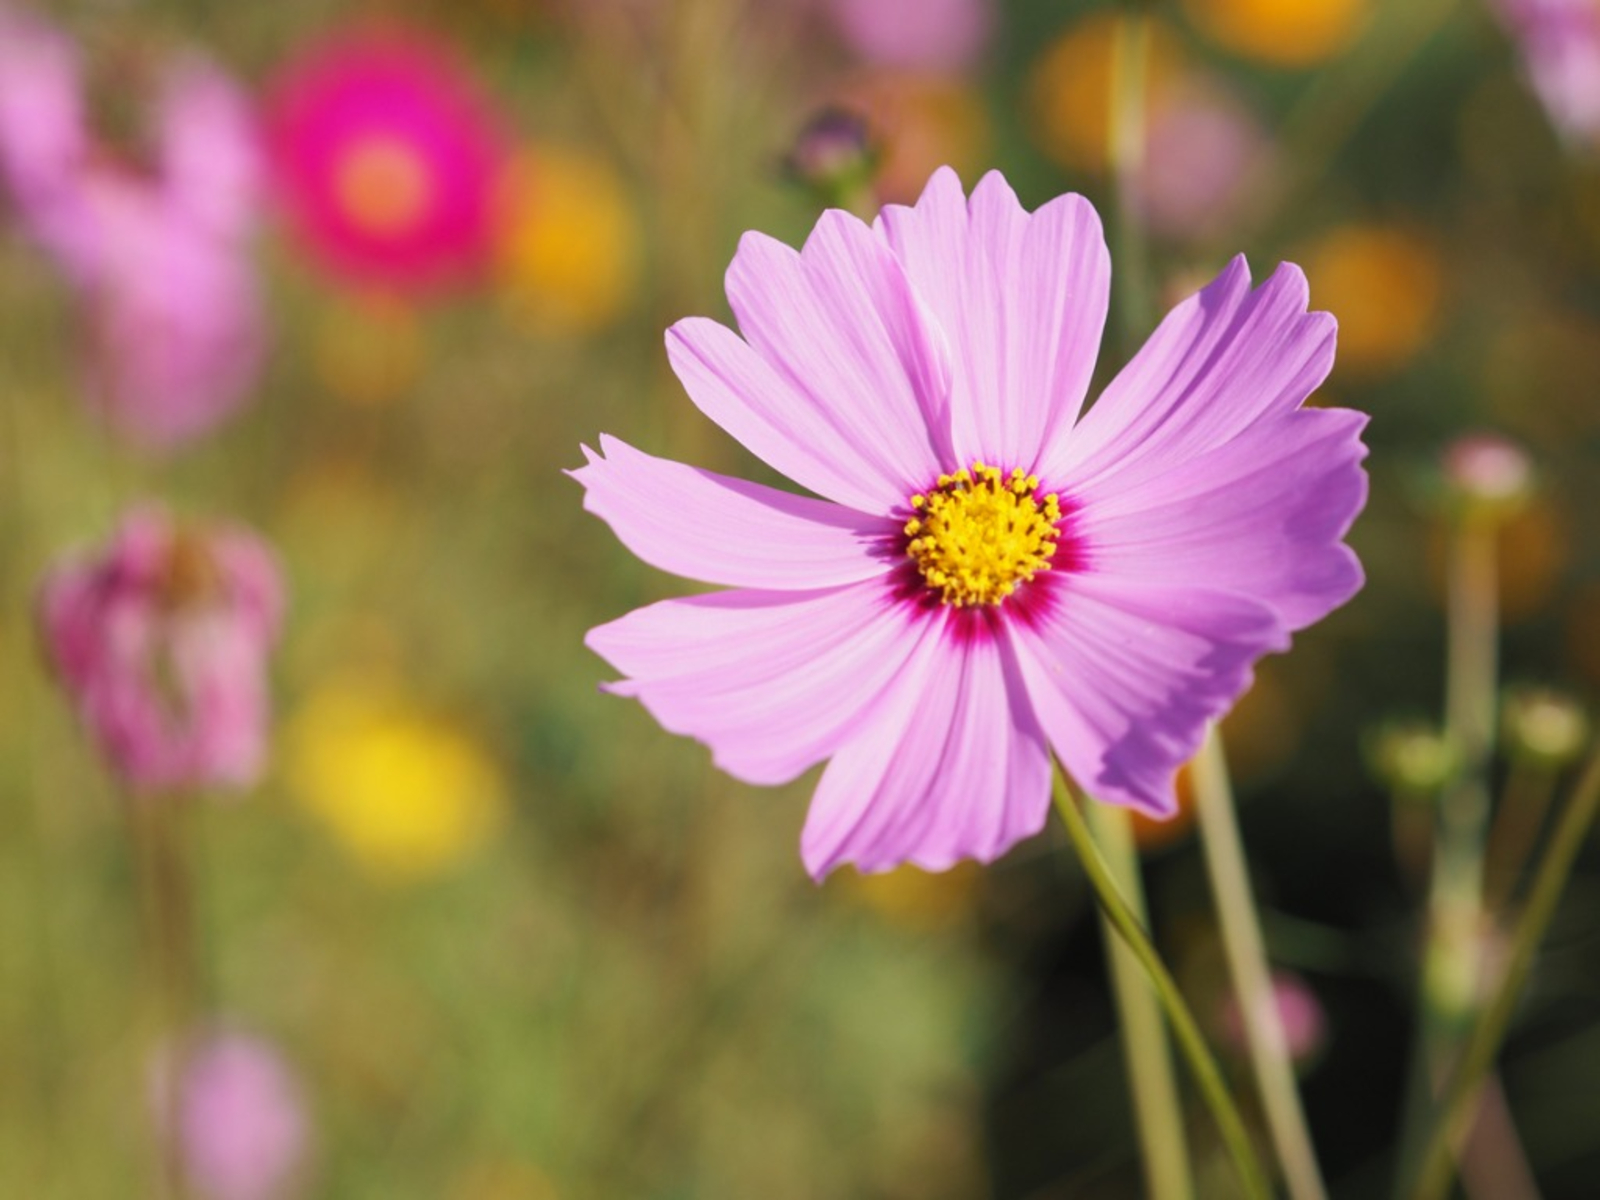

وتغنى الطير فالأزهار قد   شقت الأكمام من فرط الطرب 0.2649618685245514
أيها الوسمي زر نبت الربا   واسبق الفجر إلى روض الزهر 0.2629314959049225
زهرة تحمل فوق النيل زهرة   وشذى يلثم وجداني عطره 0.2585366666316986
فتلك عروش الياسمين وزهره   كزهر النجوم وسط أفلاكها تبدو 0.25768667459487915
ولا بعد جلق من مربع   يغص الفضاء بأزهاره 0.2569907009601593


In [ ]:
filepath = '/content/test3.jpg'
search(Image.open(filepath))

## 3. Preprocessing poems text data (Metrec dataset) 

#### 1. Prepare dataset

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from datasets import load_dataset
import re
import string
from nltk.corpus import stopwords

from tqdm import tqdm
tqdm.pandas()



In [ ]:
dataset = load_dataset("metrec")

Generating train split:   0%|          | 0/47124 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8316 [00:00<?, ? examples/s]

Dataset metrec downloaded and prepared to /root/.cache/huggingface/datasets/metrec/plain_text/1.0.0/f7b739eb73ee54df58d0159e35de5d6bdddaf2f661cc17add9f444e7167ef77c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
df_poems_train = pd.DataFrame.from_dict(dataset['train'])
df_poems_test = pd.DataFrame.from_dict(dataset['test'])

In [ ]:
df_poems_train.head()

,text,label
0,يا ضيفَ طيفٍ ما هَداهُ لمَضجَعي # إلا لهيبٌ في...,1
1,إِمامُكَ الصُبحُ كَم يَشكو دُجىً وَوَجىً # فَظ...,8
2,وعيون نرجه لنحوك قد رنت # وغدت تشير اليك بالايماء,1
3,قطعتُ مكاتبتي عنكمُ # لأجل حديثٍ إليكم يُساق,2
4,لِيَخَف صاحِبُ الدِيانَةِ وَالصَو # نِ مَقالاً...,9


In [ ]:
df_poems_test.head()

,text,label
0,حسرتي مع ذا ومع ذا فأنا # معهمُ مع بعدهم في مع...,7
1,ولا أخ عن أخ أو عن أب ولد # وما عمرناه للدنيا ...,8
2,كافلُ دينِ الله سيفٌ له # لا زالَ للأمةِ محبوبا,0
3,لَهَا شِيَةٌ مَا شِئت حُسْناً وَمِشْيَةً # تَب...,10
4,وَهُوَ بِدُنياهُ مولَعٌ كَلِفٌ # يَقنَعُ مِن ص...,4


In [ ]:
df_poems = pd.concat([df_poems_train, df_poems_test], ignore_index=True, sort=False)

In [ ]:
df_poems.drop(['label'], axis = 1, inplace= True)

In [ ]:
df_poems.head()

,text
0,يا ضيفَ طيفٍ ما هَداهُ لمَضجَعي # إلا لهيبٌ في...
1,إِمامُكَ الصُبحُ كَم يَشكو دُجىً وَوَجىً # فَظ...
2,وعيون نرجه لنحوك قد رنت # وغدت تشير اليك بالايماء
3,قطعتُ مكاتبتي عنكمُ # لأجل حديثٍ إليكم يُساق
4,لِيَخَف صاحِبُ الدِيانَةِ وَالصَو # نِ مَقالاً...


In [ ]:
df_poems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55440 entries, 0 to 55439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    55440 non-null  object
dtypes: object(1)
memory usage: 433.2+ KB


In [ ]:
def remove_digits(text):
  return re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  

def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
   
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))

    return text.translate(translator)

def normalize_arabic(text):
    #text = re.sub("[إأآا]", "ا", text)
    #text = re.sub("ئ", "ي", text)
    #text = re.sub("ى", "ي", text)
    #text = re.sub("ؤ", "ء", text)
    #text = re.sub("ئ", "ء", text)
    #text = re.sub("ة", "ه", text)
    #text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
  arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
  text = re.sub(arabic_diacritics, '', text)
  return text  

In [ ]:
df_poems['text'] = df_poems['text'].apply(lambda x: remove_digits(x))
df_poems['text'] = df_poems['text'].apply(lambda x: remove_punctuations(x))
df_poems['text'] = df_poems['text'].apply(lambda x: remove_diacritics(x))

In [ ]:
df_poems.head()

,text
0,يا ضيف طيف ما هداه لمضجعي إلا لهيب في الحشى ...
1,إمامك الصبح كم يشكو دجى ووجى فظاظة الشوك قد ...
2,وعيون نرجه لنحوك قد رنت وغدت تشير اليك بالايماء
3,قطعت مكاتبتي عنكم لأجل حديث إليكم يساق
4,ليخف صاحب الديانة والصو ن مقالا من جاهل يتحظى


In [ ]:
df_poems[0:10].to_csv('poems_embed_samples.csv')

####2. Preprocessing

In [ ]:
df_poems.head(10)

,text,text_clean
0,يا ضيف طيف ما هداه لمضجعي إلا لهيب في الحشى ...,يا ضيف طيف ما هداه لمضجعي إلا لهيب في الحشى ...
1,إمامك الصبح كم يشكو دجى ووجى فظاظة الشوك قد ...,إمامك الصبح كم يشكو دجى ووجى فظاظة الشوك قد ...
2,وعيون نرجه لنحوك قد رنت وغدت تشير اليك بالايماء,وعيون نرجه لنحوك قد رنت وغدت تشير اليك بالايماء
3,قطعت مكاتبتي عنكم لأجل حديث إليكم يساق,قطعت مكاتبتي عنكم لأجل حديث إليكم يساق
4,ليخف صاحب الديانة والصو ن مقالا من جاهل يتحظى,ليخف صاحب الديانة والصو ن مقالا من جاهل يتحظى
5,تعجبوا من عراقي بلا سفه ولا نفاق ولا خبث ولا...,تعجبوا من عراقي بلا سفه ولا نفاق ولا خبث ولا...
6,تحاذر أملاك البسيطة صوله ويأمن من صولاتها ما...,تحاذر أملاك البسيطة صوله ويأمن من صولاتها ما...
7,تذكر بالحما إذ شام برقا زمان اللهو منتسق النظام,تذكر بالحما إذ شام برقا زمان اللهو منتسق النظام
8,لقد كذب الذين طغوا فقالوا أتى من ربنا أمر برمز,لقد كذب الذين طغوا فقالوا أتى من ربنا أمر برمز
9,وما بذلوا إلا نفوسا نفيسة تحن إلى الأخرى حني...,وما بذلوا إلا نفوسا نفيسة تحن إلى الأخرى حني...


In [ ]:
import nltk
from nltk.stem.isri import ISRIStemmer
ISRIS_st = ISRIStemmer()

#ISRIS_st.stem(item) for item in
df_poems['text_clean'] = df_poems['text_clean'].progress_apply(lambda x: x.split())

100%|██████████| 55440/55440 [00:00<00:00, 97388.80it/s]


In [ ]:
df_poems['text_clean'] = df_poems['text_clean'].progress_apply(lambda x: [ISRIS_st.stem(item) for item in x])

100%|██████████| 55440/55440 [00:03<00:00, 13912.49it/s]


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Show the set of Arabic stop-words
stop = stopwords.words('arabic')

set(stopwords.words('arabic'))

{'ء',
 'ءَ',
 'آ',
 'آب',
 'آذار',
 'آض',
 'آمينَ',
 'آناء',
 'آنفا',
 'آه',
 'آها',
 'آهاً',
 'آهٍ',
 'آهِ',
 'آي',
 'أ',
 'أبدا',
 'أبريل',
 'أبو',
 'أبٌ',
 'أجل',
 'أجمع',
 'أحد',
 'أخبر',
 'أخذ',
 'أخو',
 'أخٌ',
 'أربع',
 'أربعاء',
 'أربعة',
 'أربعمئة',
 'أربعمائة',
 'أرى',
 'أسكن',
 'أصبح',
 'أصلا',
 'أضحى',
 'أطعم',
 'أعطى',
 'أعلم',
 'أغسطس',
 'أف',
 'أفريل',
 'أفعل به',
 'أفٍّ',
 'أقبل',
 'أقل',
 'أكتوبر',
 'أكثر',
 'أل',
 'ألا',
 'ألف',
 'ألفى',
 'أم',
 'أما',
 'أمام',
 'أمامك',
 'أمامكَ',
 'أمد',
 'أمس',
 'أمسى',
 'أمّا',
 'أن',
 'أنا',
 'أنبأ',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'أنتِ',
 'أنشأ',
 'أنى',
 'أنًّ',
 'أنّى',
 'أهلا',
 'أو',
 'أوت',
 'أوشك',
 'أول',
 'أولئك',
 'أولاء',
 'أولالك',
 'أوه',
 'أوّهْ',
 'أى',
 'أي',
 'أيا',
 'أيار',
 'أيضا',
 'أيلول',
 'أين',
 'أينما',
 'أيها',
 'أيّ',
 'أيّان',
 'أُفٍّ',
 'ؤ',
 'إحدى',
 'إذ',
 'إذا',
 'إذاً',
 'إذما',
 'إذن',
 'إزاء',
 'إلا',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'إليكنّ',
 'إليكَ',
 'إلَيْكَ',
 'إلّا',


In [ ]:
#Remove stop-words
df_poems['text_clean'] = df_poems['text_clean'].progress_apply(lambda x: [item for item in x if item not in stop])

100%|██████████| 55440/55440 [00:16<00:00, 3453.28it/s]


In [ ]:
df_poems['text_clean'] = df_poems['text_clean'].str.join(' ')

In [ ]:
# Save the tokenized poems into file
df_poems.to_csv('metrec_dataset_clean.csv', encoding='utf-8')